In [ ]:
from pathlib import Path

import kagglehub
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
DATA_DIR = kagglehub.dataset_download("arjuntejaswi/plant-village")
DATA_PATH = Path(DATA_DIR) / "PlantVillage"

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


In [ ]:
augmenter = keras.Sequential(
    [
        keras_cv.layers.RandomFlip("horizontal"),
        keras_cv.layers.RandomRotation(0.1),
        keras_cv.layers.RandomZoom(0.1),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 255)),
    ],
    name="augmenter",
)


def preprocess(image, label):
    image = augmenter(image)
    image = mobilenet_v2.preprocess_input(image)
    return image, label


train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds.map(
    lambda x, y: (mobilenet_v2.preprocess_input(x), y), num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

In [ ]:
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet"
)
base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3),
    TensorBoard("logs"),
]

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)

Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 223s 408ms/step - accuracy: 0.6736 - loss: 1.0118 - val_accuracy: 0.8759 - val_loss: 0.3687 - learning_rate: 0.0010
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 191s 370ms/step - accuracy: 0.8626 - loss: 0.4141 - val_accuracy: 0.8798 - val_loss: 0.3607 - learning_rate: 0.0010
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 190s 367ms/step - accuracy: 0.8806 - loss: 0.3568 - val_accuracy: 0.8900 - val_loss: 0.3326 - learning_rate: 0.0010
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 192s 372ms/step - accuracy: 0.8962 - loss: 0.2968 - val_accuracy: 0.8948 - val_loss: 0.3109 - learning_rate: 0.0010
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 192s 372ms/step - accuracy: 0.9015 - loss: 0.2784 - val_accuracy: 0.8895 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 196s 378ms/step - accuracy: 0.9113 - loss: 0.2597 - val_accuracy: 0.9089 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 197s 370ms/step - accura

129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.96      0.99      0.97       176
                     Pepper__bell___healthy       0.99      0.98      0.98       280
                      Potato___Early_blight       0.99      0.95      0.97       194
                       Potato___Late_blight       0.91      0.97      0.94       224
                           Potato___healthy       0.90      0.90      0.90        29
                      Tomato_Bacterial_spot       0.93      0.97      0.95       414
                        Tomato_Early_blight       0.95      0.72      0.82       200
                         Tomato_Late_blight       0.93      0.95      0.94       369
                           Tomato_Leaf_Mold       0.93      0.93      0.93       208
                  Tomato_Septoria_leaf_spot       0.91      0.93      0.92       337
Tomato_Spider_mites_T

<Figure size 1200x1200 with 0 Axes>

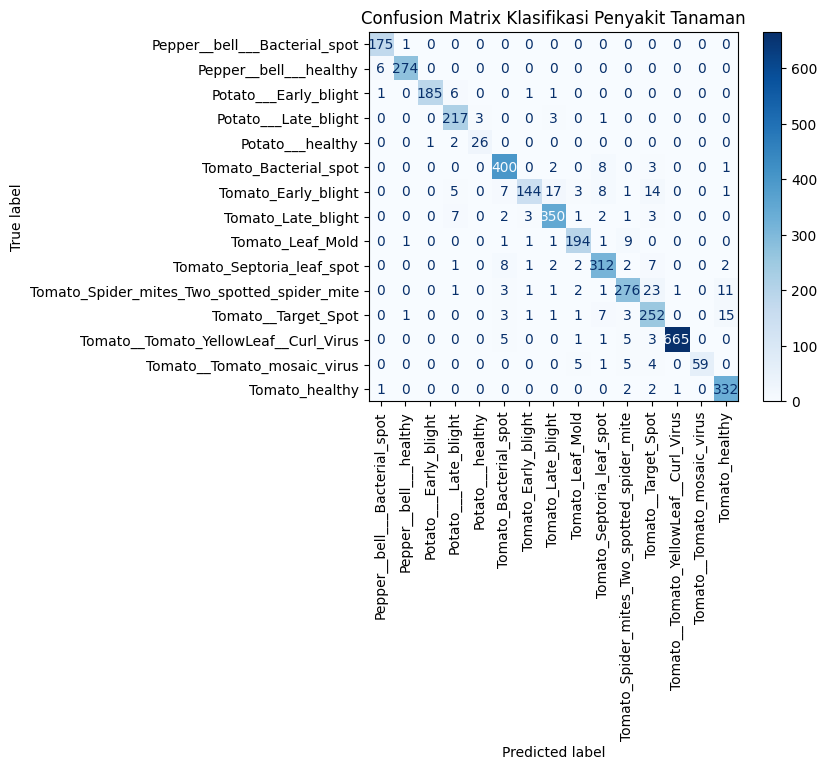

In [ ]:
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

pred_probs = model.predict(val_images, batch_size=32)
pred_labels = np.argmax(pred_probs, axis=1)

# Classification report with F1-score
print(classification_report(val_labels, pred_labels, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(val_labels, pred_labels)
plt.figure(figsize=(12, 12))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(
    xticks_rotation=90, cmap="Blues"
)
plt.title("Confusion Matrix Klasifikasi Penyakit Tanaman")
plt.show()